In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

# Call rank

In [2]:
rank = pd.read_csv("C:\\Users\\ASUS\\Desktop\\AI Project\\Spam Calls SPIT\\icaller-data\\icaller_data_Long\\results.csv")

In [3]:
rank = rank.set_index('SDT')
rank

,Unnamed: 0,CallRank
SDT,,
12166322545,0,0.275633
12347579491,1,0.275633
12396455399,2,0.275633
12543891391,3,0.275633
12703485130,4,0.275633
...,...,...
998936204202,288967,0.284977
998990144636,288968,0.285996
998990721816,288969,0.305534


In [4]:
rank_dict = rank.transpose().to_dict()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [5]:
df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\AI Project\\Spam Calls SPIT\\icaller-data\\icaller_data_Long\\clean\\icaller_data_test.csv")
df['callto_callin'] = df.call_to/(df.call_in+0.00000001)
del df['call_to']
del df['call_in']
del df['call_to_miss']
del df['call_in_miss']
del df['duration_call_to']
del df['duration_call_in']
del df['in_hour']
df

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,Spam,callto_callin
0,842473000991,47.199056,0.000000,0.000000,0.400000,0,1,2.000000e+08
1,842499950216,0.000000,32.777414,0.009615,0.067308,2,1,1.111111e-01
2,842499959998,8.361436,0.000000,0.000000,0.802326,0,1,8.100000e+09
3,842835214389,23.204493,0.000000,0.000000,0.250000,0,1,1.500000e+09
4,842838664080,3.794869,46.748831,0.041322,0.132231,57,1,1.400000e+01
...,...,...,...,...,...,...,...,...
2525,84869607598,5.249869,10.641293,0.031250,0.260417,75,0,8.695652e-02
2526,84903018040,7.749806,20.405350,0.658537,0.682927,18,0,8.823529e-02
2527,84966699609,26.571353,51.593589,0.179104,0.850746,60,0,8.750000e-01
2528,84392823504,51.156090,15.257553,0.846939,0.438776,57,0,8.400000e-01


In [6]:
tam =[]
for i in range(len(df)):
    try:
        tam.append(rank_dict[int(df.phone[i])]['CallRank'])
    except:
        tam.append(0)

In [7]:
df['rank']=tam

In [8]:
features=['phone','avg_duration_call_to','avg_duration_call_in','avg_in_contact','avg_success','cung_mang','callto_callin','rank','Spam']
df = df[features]

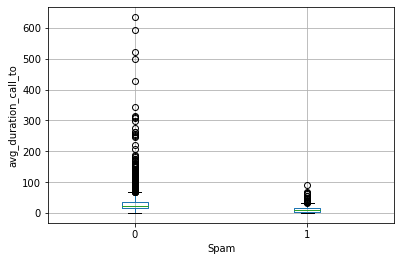

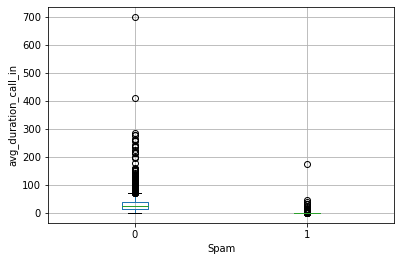

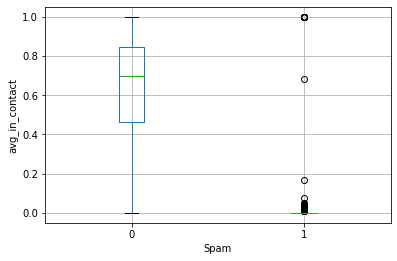

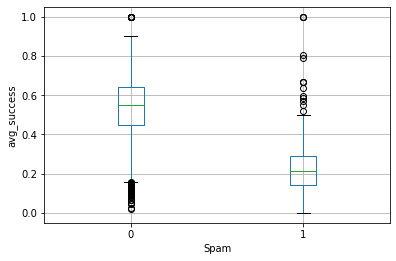

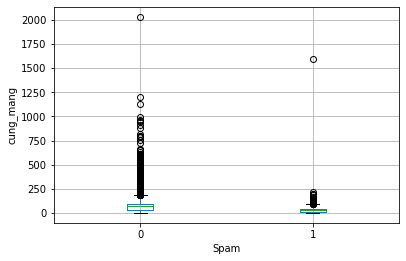

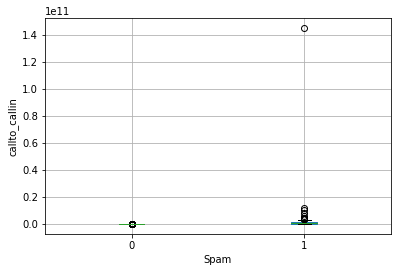

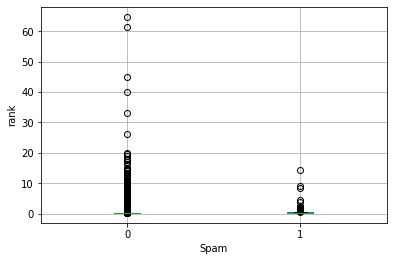

In [9]:
col= df.columns.tolist()[1:-1]
for i in range(0 , len(col)) :
    ax = df.boxplot(column= col[i], by='Spam')
    ax.set_ylabel(col[i])
    plt.suptitle('') # Suppress the titles
    plt.title('')

In [10]:
from collections import Counter
X = df.drop(columns=['phone','Spam'])
y = df['Spam']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

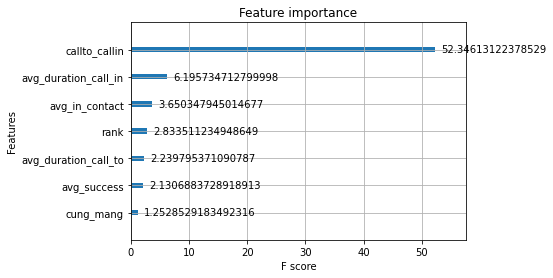

In [11]:
from xgboost import XGBClassifier
from xgboost import plot_importance
# fit model no training data
XGB = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=150, eta=0.3, subsample=1, colsample_bytree=1)
XGB.fit(X, y)
# plot feature importance
plot_importance(XGB,importance_type = 'gain')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort


X = df.drop(columns=['phone','Spam'])
Y = df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,  random_state=3)

# fit model on all training data
XGB = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=150, eta=0.3, subsample=1, colsample_bytree=1)
XGB.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = XGB.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(XGB.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(XGB, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 99.21%
Thresh=0.012, n=7, Accuracy: 99.08%
Thresh=0.014, n=6, Accuracy: 98.95%
Thresh=0.016, n=5, Accuracy: 98.95%
Thresh=0.019, n=4, Accuracy: 98.55%
Thresh=0.027, n=3, Accuracy: 98.68%
Thresh=0.036, n=2, Accuracy: 98.29%
Thresh=0.876, n=1, Accuracy: 98.29%


In [13]:
from numpy import mean
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


XGB = xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=150, eta=0.3, subsample=1, colsample_bytree=1)
# define model
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(XGB, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.99972


# Split and SMOTE

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['phone','Spam'])
Y = df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,  random_state=3)
print(X_train.shape, y_train.shape)

#Clean outlier
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]
print(X_train.shape, y_train.shape)

(1771, 7) (1771,)
(1594, 7) (1594,)


In [15]:
# from imblearn.over_sampling import SVMSMOTE, SMOTE

# # oversample = SVMSMOTE(m_neighbors=20,k_neighbors=20)
# oversample = SMOTE(k_neighbors=20)
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# # t=Xt
# # t['Spam']=yt

In [16]:
features=['avg_duration_call_to','avg_duration_call_in','avg_in_contact','avg_success','cung_mang','callto_callin','rank']
X_train =  pd.DataFrame( X_train , columns=features )
y_train =  pd.DataFrame( y_train , columns=['Spam'] )


-------------------------------------XGBClassifier----------------------------------------------------------
[0]	validation_0-logloss:0.600333	validation_1-logloss:0.602882
[1]	validation_0-logloss:0.524248	validation_1-logloss:0.528947
[2]	validation_0-logloss:0.46074	validation_1-logloss:0.467281
[3]	validation_0-logloss:0.407052	validation_1-logloss:0.415588
[4]	validation_0-logloss:0.36067	validation_1-logloss:0.370913
[5]	validation_0-logloss:0.32066	validation_1-logloss:0.332398
[6]	validation_0-logloss:0.285944	validation_1-logloss:0.299083
[7]	validation_0-logloss:0.255663	validation_1-logloss:0.270076
[8]	validation_0-logloss:0.229109	validation_1-logloss:0.244933
[9]	validation_0-logloss:0.205734	validation_1-logloss:0.222954
[10]	validation_0-logloss:0.185079	validation_1-logloss:0.203404
[11]	validation_0-logloss:0.166655	validation_1-logloss:0.185725
[12]	validation_0-logloss:0.150303	validation_1-logloss:0.170437
[13]	validation_0-logloss:0.135902	validation_1-logloss:0.1

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[100]	validation_0-logloss:0.002308	validation_1-logloss:0.041126
[101]	validation_0-logloss:0.002295	validation_1-logloss:0.041149
[102]	validation_0-logloss:0.002282	validation_1-logloss:0.041135
[103]	validation_0-logloss:0.00227	validation_1-logloss:0.041045
[104]	validation_0-logloss:0.002259	validation_1-logloss:0.041069
[105]	validation_0-logloss:0.002248	validation_1-logloss:0.041058
[106]	validation_0-logloss:0.002238	validation_1-logloss:0.041082
[107]	validation_0-logloss:0.002228	validation_1-logloss:0.041072
[108]	validation_0-logloss:0.002219	validation_1-logloss:0.041096
[109]	validation_0-logloss:0.002211	validation_1-logloss:0.041183
[110]	validation_0-logloss:0.002203	validation_1-logloss:0.041204
[111]	validation_0-logloss:0.002195	validation_1-logloss:0.041285
[112]	validation_0-logloss:0.002188	validation_1-logloss:0.041304
[113]	validation_0-logloss:0.002181	validation_1-logloss:0.041381
[114]	validation_0-logloss:0.002174	validation_1-logloss:0.041398
[115]	valid

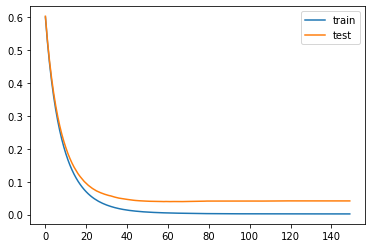

In [17]:
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
def KQ(y_test,prediction_train,prediction_test):
    print('Accuracy_train:', accuracy_score(y_train, prediction_train))
    print('Accuracy_test:', accuracy_score(y_test, prediction_test))
    print('F1 score:', f1_score(y_test, prediction_test))
    print('Recall:', recall_score(y_test, prediction_test))
    print('Precision:', precision_score(y_test, prediction_test))
   # print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction_test))
# print(len(df_non))
Score = []
F1_score = []
Recall = []
Precision =  []

# XGBClassifier
print('-------------------------------------XGBClassifier----------------------------------------------------------')
import xgboost as xgb
XGB = xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=150, eta=0.3, subsample=1, colsample_bytree=1)

# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test, y_test)]
# fit the model
XGB.fit(X_train, y_train , eval_metric='logloss', eval_set=evalset)


prediction_train = XGB.predict(X_train)
prediction_test =XGB.predict(X_test)

predict_proba = XGB.predict_proba(X_test)


KQ(y_test,prediction_train,prediction_test)
Score.append(accuracy_score(y_test, prediction_test))
F1_score.append(f1_score(y_test, prediction_test))
Recall.append(recall_score(y_test, prediction_test))
Precision.append(precision_score(y_test, prediction_test))

# retrieve performance metrics
results = XGB.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

# PRC

Best Threshold=0.135404, F-Score=0.958


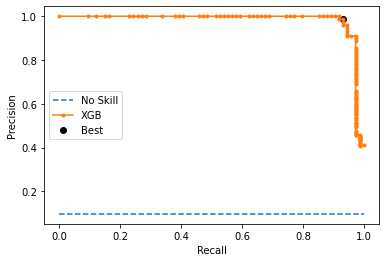

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
from math import sqrt
from sklearn.metrics import precision_recall_curve
proba = predict_proba[:,1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, proba)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGB')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# ROC AUC


Random (chance) Prediction: AUROC = 0.500
XGB
             : AUROC = 0.996


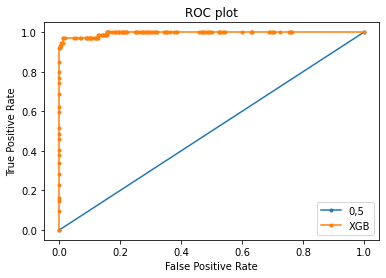

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
classifiers = [ XGB ]
classifiers_name = [ 'XGB' ]
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs )
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
plt.plot(r_fpr, r_tpr, marker='.', label = '0,5' % (r_auc))
AUC_clean = []
for i in range(len(classifiers_name)):
    i_probs = classifiers[i].predict_proba(X_test)
    i_probs = i_probs[:,1]
    i_auc = roc_auc_score(y_test, i_probs)
    i_fpr, i_tpr, _ = roc_curve(y_test, i_probs )
    print(classifiers_name[i])
    print('             : AUROC = %.3f' % (i_auc))
    AUC_clean.append(i_auc)
    plt.plot(i_fpr, i_tpr, marker='.', label = classifiers_name[i] % (i_auc))
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


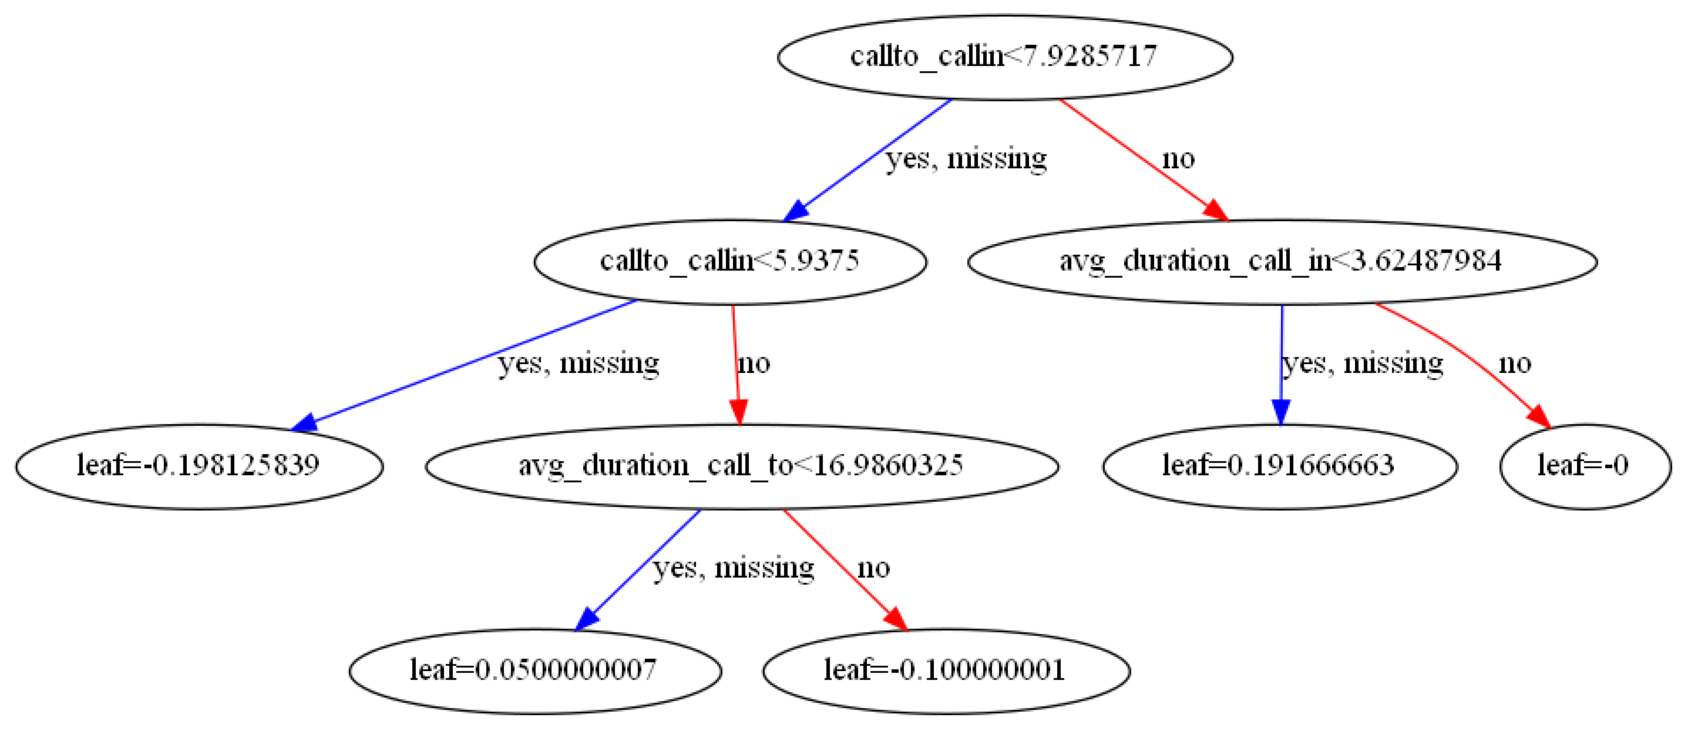

In [20]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax)
plt.savefig('tree.png')
plt.show()
# plot_tree(XGB,num_trees=0, rankdir='LR')

# plt.show()
                       

In [21]:
# from collections import Counter
# Counter(stick_label.loc[stick_label.avg_duration_call_to < 0.614582062].Spam)

# Not label

In [22]:
notlabel = pd.read_csv("C:\\Users\\ASUS\\Desktop\\AI Project\\Spam Calls SPIT\\icaller-data\\icaller_data_Long\\clean\\notlabel_clean_new.csv")
notlabel

,phone,call_to,call_in,call_to_miss,call_in_miss,duration_call_to,duration_call_in,avg_duration_call_to,avg_duration_call_in,avg_in_contact,in_hour,avg_success,cung_mang,Spam
0,842437710404,1,2,0,0,75.0,215.0,74.992501,107.494625,0.000000,3,1.000000,0,0
1,842437824654,2,0,0,0,7.0,0.0,3.499825,0.000000,1.000000,1,0.000000,0,0
2,842437835527,3,1,0,1,120.0,26.0,39.998667,12.999350,0.000000,5,0.800000,0,0
3,842437836363,3,0,0,0,42.0,0.0,13.999533,0.000000,0.333333,3,1.000000,0,0
4,842437938828,3,1,0,0,185.0,12.0,61.664611,11.998800,0.000000,4,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167984,998995279591,4,6,0,0,563.0,1434.0,140.746481,238.996017,0.000000,6,1.000000,10,0
167985,998995720517,0,0,0,14,0.0,0.0,0.000000,0.000000,0.000000,0,0.000000,14,0
167986,999,10,0,24,38,179.0,0.0,5.264690,0.000000,0.027778,48,0.083333,1,0
167987,9999,0,0,0,2,0.0,0.0,0.000000,0.000000,0.000000,1,0.000000,0,0


In [23]:
notlabel['callto_callin'] = notlabel.call_to/(notlabel.call_in+0.00000001)

del notlabel['call_to']
del notlabel['call_in']
del notlabel['call_to_miss']
del notlabel['call_in_miss']
del notlabel['duration_call_to']
del notlabel['duration_call_in']
del notlabel['in_hour']


In [24]:
tam =[]
for i in range(len( notlabel)):
    try:
        tam.append(rank_dict[int( notlabel.phone[i])]['CallRank'])
    except:
        tam.append(0)
    

In [25]:
notlabel['rank'] = tam

In [26]:
notlabel

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,Spam,callto_callin,rank
0,842437710404,74.992501,107.494625,0.000000,1.000000,0,0,5.000000e-01,0.278466
1,842437824654,3.499825,0.000000,1.000000,0.000000,0,0,2.000000e+08,0.275658
2,842437835527,39.998667,12.999350,0.000000,0.800000,0,0,3.000000e+00,0.282332
3,842437836363,13.999533,0.000000,0.333333,1.000000,0,0,3.000000e+08,0.276465
4,842437938828,61.664611,11.998800,0.000000,1.000000,0,0,3.000000e+00,0.295109
...,...,...,...,...,...,...,...,...,...
167984,998995279591,140.746481,238.996017,0.000000,1.000000,10,0,6.666667e-01,0.371284
167985,998995720517,0.000000,0.000000,0.000000,0.000000,14,0,0.000000e+00,0.000000
167986,999,5.264690,0.000000,0.027778,0.083333,1,0,1.000000e+09,0.275633
167987,9999,0.000000,0.000000,0.000000,0.000000,0,0,0.000000e+00,0.000000


In [27]:
P = notlabel['phone']
X = notlabel.drop(columns=['Spam','phone'])
Y = notlabel['Spam']

# stick the label

In [28]:
prediction_notlabel =XGB.predict(X)
predict_proba = XGB.predict_proba(X)

In [29]:
proba = predict_proba[:,1]

In [30]:
X['Spam'] = prediction_notlabel
X['Proba'] = proba

In [31]:
stick_label = pd.concat([P,X],axis=1)

In [32]:
stick_label.groupby(['Spam']).count()

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,callto_callin,rank,Proba
Spam,,,,,,,,,
0,111337,111337,111337,111337,111337,111337,111337,111337,111337
1,56652,56652,56652,56652,56652,56652,56652,56652,56652


In [33]:
stick_label.loc[stick_label.Proba>thresholds[ix]]

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,callto_callin,rank,Spam,Proba
1,842437824654,3.499825,0.0000,1.000000,0.000000,0,2.000000e+08,0.275658,1,0.537322
3,842437836363,13.999533,0.0000,0.333333,1.000000,0,3.000000e+08,0.276465,1,0.904149
4,842437938828,61.664611,11.9988,0.000000,1.000000,0,3.000000e+00,0.295109,0,0.255449
6,842437955798,87.995600,0.0000,0.000000,1.000000,0,2.000000e+08,0.287337,1,0.997357
7,842437959595,163.994534,0.0000,1.000000,0.400000,0,2.000000e+08,0.349713,1,0.997051
...,...,...,...,...,...,...,...,...,...,...
167964,992556004865,85.330489,0.0000,0.000000,0.400000,5,2.000000e+08,0.298844,1,0.998997
167973,99877563,3.599928,0.0000,0.000000,0.400000,0,2.000000e+08,0.278295,1,0.986835
167976,998936204202,27.498625,0.0000,1.000000,0.285714,7,2.000000e+08,0.284977,1,0.994462
167980,998990144636,20.332656,0.0000,1.000000,0.600000,5,3.000000e+08,0.285996,1,0.994462


In [34]:
spam = stick_label.loc[stick_label.Spam == 1]

In [35]:
spam.describe()

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,callto_callin,rank,Spam,Proba
count,5.665200e+04,56652.000000,56652.000000,56652.000000,56652.000000,56652.000000,5.665200e+04,56652.000000,56652.0,56652.000000
mean,1.333277e+11,37.295633,1.250414,0.431615,0.570704,4.543458,2.589917e+08,0.343460,1.0,0.957566
std,3.571683e+12,74.480480,9.453564,0.491645,0.323566,9.569939,4.900354e+08,0.439536,0.0,0.096464
min,8.989000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.275633,1.0,0.500326
25%,8.456336e+10,9.333178,0.000000,0.000000,0.333333,0.000000,1.000000e+08,0.278863,1.0,0.976648
50%,8.491183e+10,18.999050,0.000000,0.000000,0.500000,3.000000,2.000000e+08,0.286305,1.0,0.988815
75%,8.496937e+10,37.498125,0.000000,1.000000,1.000000,5.000000,3.000000e+08,0.309872,1.0,0.997403
max,8.488224e+14,2339.883006,664.966752,1.000000,1.000000,579.000000,5.550000e+10,39.896938,1.0,0.999206


In [36]:
not_spam = stick_label.loc[stick_label.Spam == 0]

In [37]:
not_spam.describe()

,phone,avg_duration_call_to,avg_duration_call_in,avg_in_contact,avg_success,cung_mang,callto_callin,rank,Spam,Proba
count,1.113370e+05,111337.000000,111337.000000,111337.000000,111337.000000,111337.000000,1.113370e+05,111337.000000,111337.0,111337.000000
mean,7.785626e+13,26.087288,30.830312,0.687341,0.491754,6.725787,6.646576e+04,0.298677,0.0,0.062646
std,2.531328e+16,63.562342,68.838324,0.456885,0.350571,16.418852,8.960639e+06,0.605754,0.0,0.094581
min,8.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000156
25%,8.439397e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.275633,0.0,0.004896
50%,8.490780e+10,12.332922,15.998400,1.000000,0.562500,3.000000,5.000000e-01,0.278065,0.0,0.015950
75%,8.496513e+10,28.999420,32.499188,1.000000,0.764706,7.000000,1.250000e+00,0.289403,0.0,0.068120
max,8.445466e+18,3745.625437,2798.180045,1.000000,1.000000,1220.000000,2.600000e+09,69.003601,0.0,0.498824
